In [40]:
# Load all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import os
import requests
import urllib.request
import IPython.display as display
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [41]:
# Define file paths
data_dir = "../project1"
hurricane_nc_path = os.path.join(data_dir, "IBTrACS.NA.v04r00.nc")
enso_path = os.path.join(data_dir, "enso_data.txt")

# Ensure the data directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download IBTrACS Hurricane Data if not found
ibtracs_url = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc"

if not os.path.exists(hurricane_nc_path):
    print("Downloading IBTrACS hurricane data...")
    try:
        response = requests.get(ibtracs_url, timeout=60)
        response.raise_for_status()  # Raise an error if the request failed
        with open(hurricane_nc_path, "wb") as f:
            f.write(response.content)
        print("IBTrACS file downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")

# Load NetCDF hurricane data
try:
    ds = xr.open_dataset(hurricane_nc_path)
except Exception as e:
    print(f"Request failed: {e}")

# Convert NetCDF dataset to Pandas DataFrame
df_hurricane = ds.to_dataframe().reset_index()

# Select relevant columns based on dataset structure
df_hurricane = df_hurricane.loc[:, ["sid", "season", "time", "lat", "lon", "usa_wind"]].copy()

# Rename columns for clarity
df_hurricane.columns = ["Storm_ID", "Year", "ISO_Time", "Latitude", "Longitude", "Storm_Intensity"]

# Decode `sid` from bytes to string
df_hurricane["Storm_ID"] = df_hurricane["Storm_ID"].str.decode("utf-8")

# Convert Year to integer (from float)
df_hurricane["Year"] = df_hurricane["Year"].astype(int)

# Filter years from 1950 onwards
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Convert `ISO_Time` to datetime format
df_hurricane["ISO_Time"] = pd.to_datetime(df_hurricane["ISO_Time"], errors="coerce")

# Drop rows where conversion failed
df_hurricane = df_hurricane.dropna(subset=["ISO_Time"])

# Extract Month safely
df_hurricane["Month"] = df_hurricane["ISO_Time"].dt.month.astype(int)

# Convert Month from number to text for merging with ENSO
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_hurricane["Month"] = df_hurricane["Month"].map(month_map)

# Define hurricane category mapping (based on wind speed in knots)
def categorize_hurricane(wind_speed):
    if wind_speed < 64:
        return "Tropical Storm"
    elif 64 <= wind_speed <= 82:
        return "Category 1"
    elif 83 <= wind_speed <= 95:
        return "Category 2"
    elif 96 <= wind_speed <= 112:
        return "Category 3"
    elif 113 <= wind_speed <= 136:
        return "Category 4"
    else:
        return "Category 5"

# Apply category mapping
df_hurricane["Category"] = df_hurricane["Storm_Intensity"].apply(categorize_hurricane)

# Save the cleaned dataset
df_hurricane.to_csv("../project1/hurricane_cleaned.csv", index=False)


In [42]:
#Cleaning ENSO table

# Load ENSO data
df_enso = pd.read_csv(enso_path, sep=r'\s+', header=None)

# Rename columns
df_enso.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Remove non-numeric rows (e.g., headers, footers)
df_enso = df_enso[df_enso["Year"].astype(str).str.match(r'^\d{4}$')]

# Convert Year to integer
df_enso["Year"] = df_enso["Year"].astype(int)

# Convert to long format
df_enso_long = df_enso.melt(id_vars=["Year"], var_name="Month", value_name="SST_Anomaly")

# Convert SST_Anomaly to numeric
df_enso_long["SST_Anomaly"] = pd.to_numeric(df_enso_long["SST_Anomaly"], errors="coerce")

# Sort values (important for applying 5-month rule)
df_enso_long = df_enso_long.sort_values(by=["Year", "Month"]).reset_index(drop=True)

# Initialize ENSO phase column
df_enso_long["ENSO_Phase"] = "Neutral"

# Function to apply 5-month rule
def detect_enso_events(df):
    consecutive_count = 0
    current_phase = "Neutral"
    
    for i in range(len(df)):
        anomaly = df.loc[i, "SST_Anomaly"]

        # Determine the phase for this month
        if anomaly >= 0.5:
            phase = "El Niño"
        elif anomaly <= -0.5:
            phase = "La Niña"
        else:
            phase = "Neutral"

        # If we are continuing the same phase, increase count
        if phase == current_phase:
            consecutive_count += 1
        else:
            # If we switch phases, reset the counter
            consecutive_count = 1
            current_phase = phase

        # If phase has lasted for at least 5 months, apply to previous months
        if consecutive_count >= 5:
            for j in range(i - 4, i + 1):
                df.loc[j, "ENSO_Phase"] = current_phase  # Apply to previous 5 months

    return df

# Apply 5-month rule
df_enso_long = detect_enso_events(df_enso_long)
df_enso_long.to_csv("../project1/enso_cleaned.csv", index=False)
df_enso_long

,Year,Month,SST_Anomaly,ENSO_Phase
0,1870,Apr,-0.81,La Niña
1,1870,Aug,-0.88,La Niña
2,1870,Dec,-0.79,La Niña
3,1870,Feb,-1.20,La Niña
4,1870,Jan,-1.00,La Niña
...,...,...,...,...
1843,2023,Mar,-0.13,Neutral
1844,2023,May,0.47,Neutral
1845,2023,Nov,2.01,Neutral
1846,2023,Oct,1.59,Neutral


In [43]:
#merge ENSO and hurricane data together
df_hurricane["Year"] = df_hurricane["Year"].astype(int)
df_hurricane["Month"] = df_hurricane["Month"].astype(str)

df_enso_long["Year"] = df_enso_long["Year"].astype(int)
df_enso_long["Month"] = df_enso_long["Month"].astype(str)
df_enso_long = df_enso_long[df_enso_long["Year"] >= 1950]

# Define a dictionary to map abbreviated month names to full names
month_map = {
    "Jan": "January", "Feb": "February", "Mar": "March", "Apr": "April", "May": "May", "Jun": "June",
    "Jul": "July", "Aug": "August", "Sep": "September", "Oct": "October", "Nov": "November", "Dec": "December"
}

# Apply the mapping
df_hurricane["Month"] = df_hurricane["Month"].map(month_map)
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].map(month_map)

# Ensure all Month values are consistent by stripping spaces
df_hurricane["Month"] = df_hurricane["Month"].str.strip()
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].str.strip()

# Convert to lowercase (optional but helps prevent mismatches)
df_hurricane["Month"] = df_hurricane["Month"].str.capitalize()
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].str.capitalize()
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Merge hurricane data with ENSO data on Year & Month
df_merged_ENSO = df_hurricane.merge(df_enso_long, on=["Year", "Month"], how="left")

# Save merged dataset
df_merged_ENSO.to_csv("../project1/merged_enso.csv", index=False)

df_merged_ENSO


,Storm_ID,Year,ISO_Time,Latitude,Longitude,Storm_Intensity,Month,Category,SST_Anomaly,ENSO_Phase
0,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
1,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
2,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
3,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
4,1950224N17305,1950,1950-08-12 03:00:00.000040448,17.417561,-55.872150,37.0,August,Tropical Storm,-0.63,La Niña
...,...,...,...,...,...,...,...,...,...,...
258355,2023321N15278,2023,2023-11-17 21:00:00.000039936,18.596569,-77.843597,30.0,November,Tropical Storm,2.01,Neutral
258356,2023321N15278,2023,2023-11-18 00:00:00.000039936,19.250000,-77.199997,30.0,November,Tropical Storm,2.01,Neutral
258357,2023321N15278,2023,2023-11-18 00:00:00.000039936,19.250000,-77.199997,30.0,November,Tropical Storm,2.01,Neutral
258358,2023321N15278,2023,2023-11-18 00:00:00.000039936,19.250000,-77.199997,30.0,November,Tropical Storm,2.01,Neutral


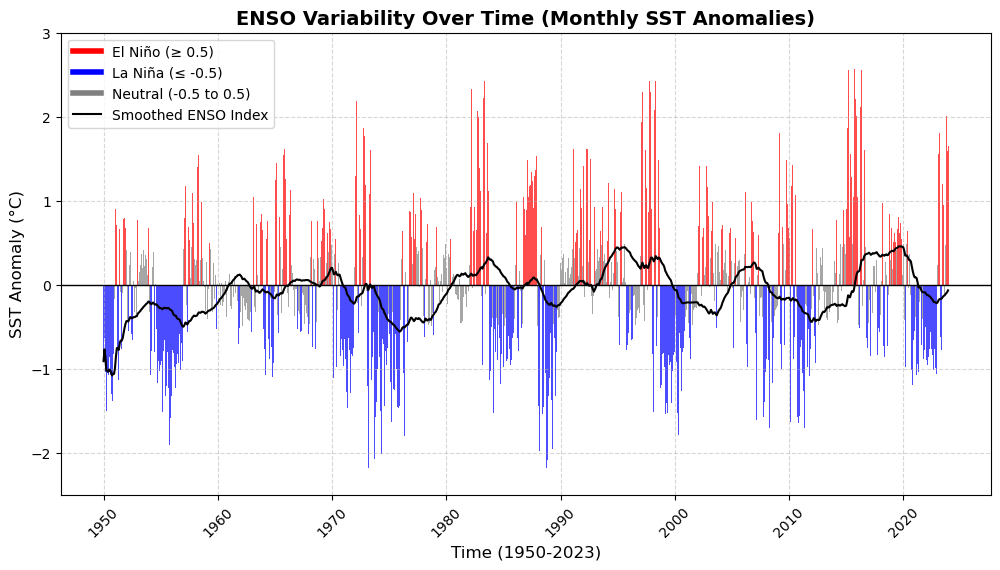

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Aggregate by Month (Average SST anomaly per month across years)
df_monthly = df_enso_long.groupby(["Year", "Month"])["SST_Anomaly"].mean().reset_index()

# Set up figure
plt.figure(figsize=(12, 6))

# Define ENSO colors
enso_colors = df_monthly["SST_Anomaly"].apply(lambda x: "red" if x >= 0.5 else "blue" if x <= -0.5 else "gray")

# Create bar plot for monthly SST anomalies
plt.bar(df_monthly.index, df_monthly["SST_Anomaly"], color=enso_colors, width=1.0, alpha=0.7)

# Add smoothed 5-year rolling mean to show ENSO variability over time
df_monthly["Rolling_MEI"] = df_monthly["SST_Anomaly"].rolling(60, min_periods=1).mean()
plt.plot(df_monthly.index, df_monthly["Rolling_MEI"], color="black", linewidth=1.5, label="Smoothed ENSO Index (5-Year Rolling Mean)")

# Add zero reference line
plt.axhline(0, color="black", linewidth=1)

# Labels and title
plt.xlabel("Time (1950-2023)", fontsize=12)
plt.ylabel("SST Anomaly (°C)", fontsize=12)
plt.title("ENSO Variability Over Time (Monthly SST Anomalies)", fontsize=14, fontweight="bold")

# Format x-axis
plt.xticks(np.arange(0, len(df_monthly), step=120), df_monthly["Year"].iloc[::120].astype(int), rotation=45)  # Show every 10 years
plt.ylim(-2.5, 3)

# Add grid for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Add legend
legend_labels = [
    plt.Line2D([0], [0], color="red", linewidth=4, label="El Niño (≥ 0.5)"),
    plt.Line2D([0], [0], color="blue", linewidth=4, label="La Niña (≤ -0.5)"),
    plt.Line2D([0], [0], color="gray", linewidth=4, label="Neutral (-0.5 to 0.5)"),
    plt.Line2D([0], [0], color="black", linewidth=1.5, label="Smoothed ENSO Index")
]
plt.legend(handles=legend_labels, loc="upper left")

# Show the plot
plt.show()



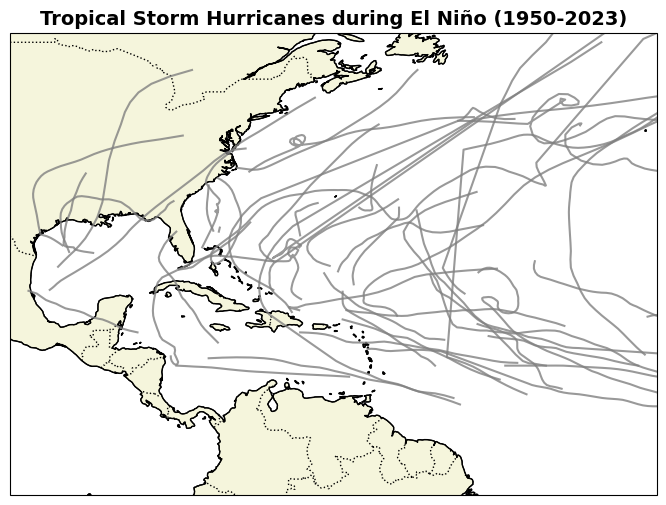

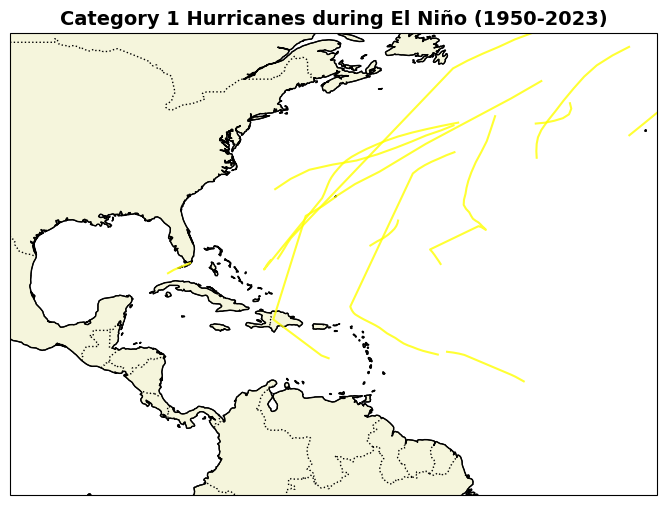

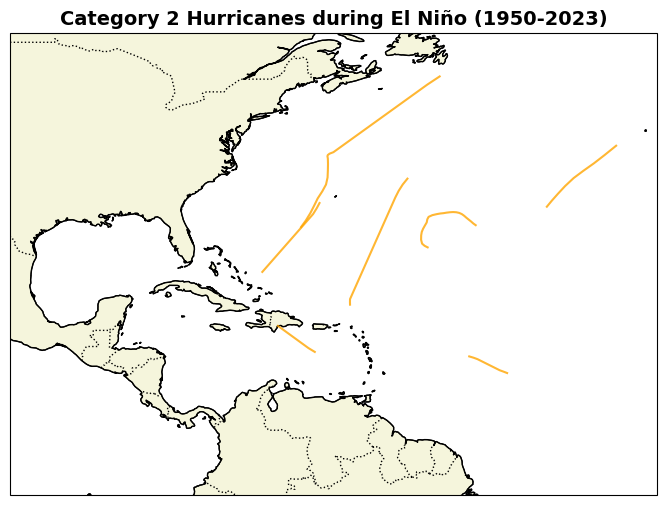

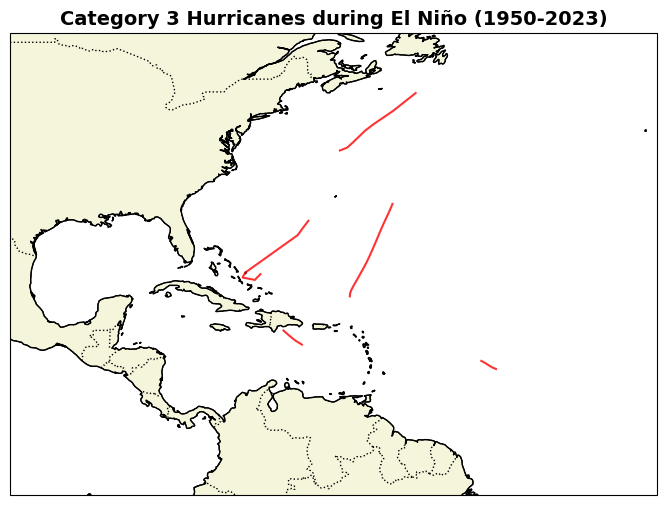

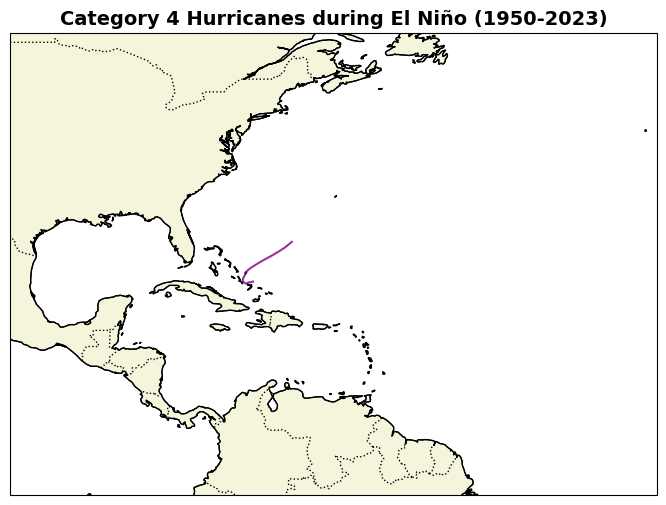

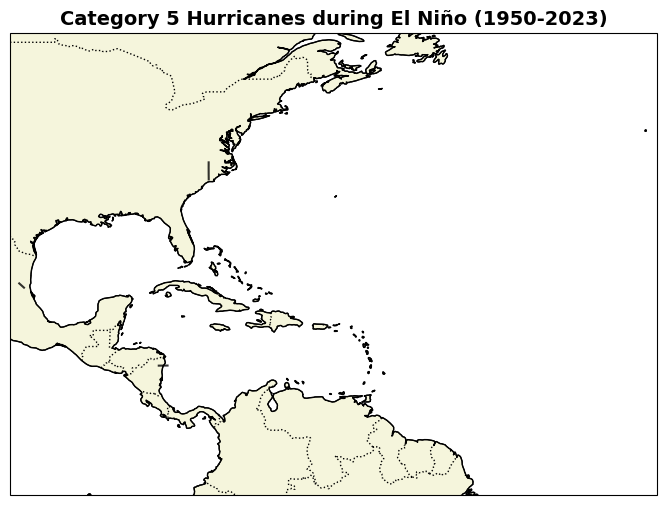

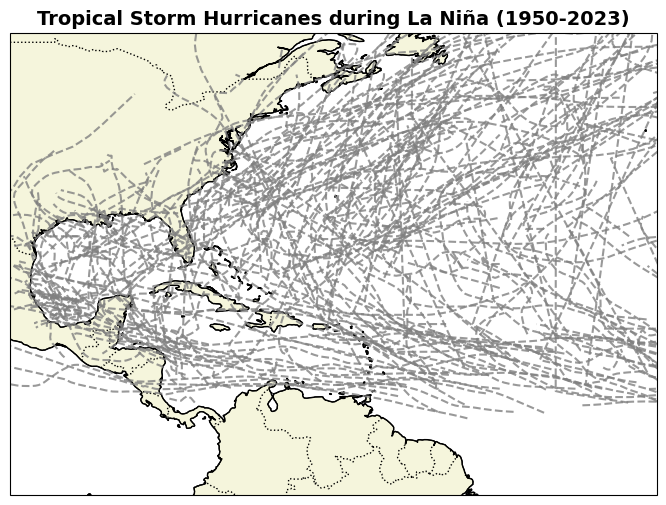

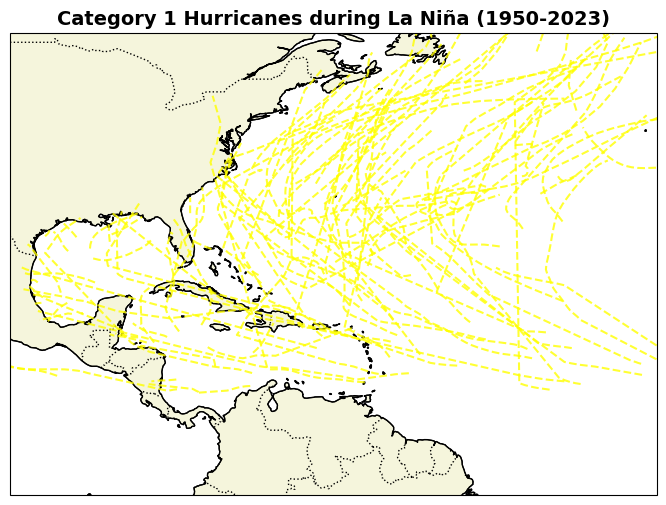

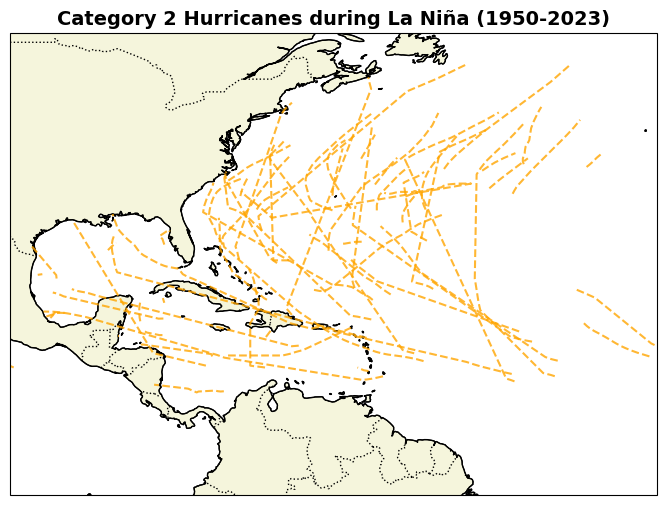

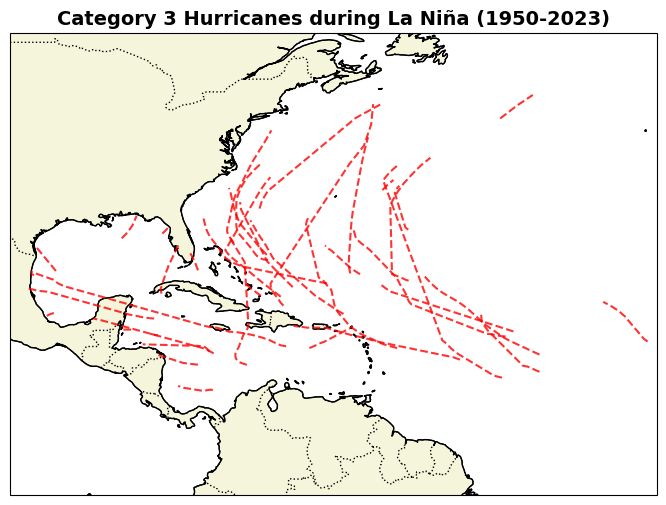

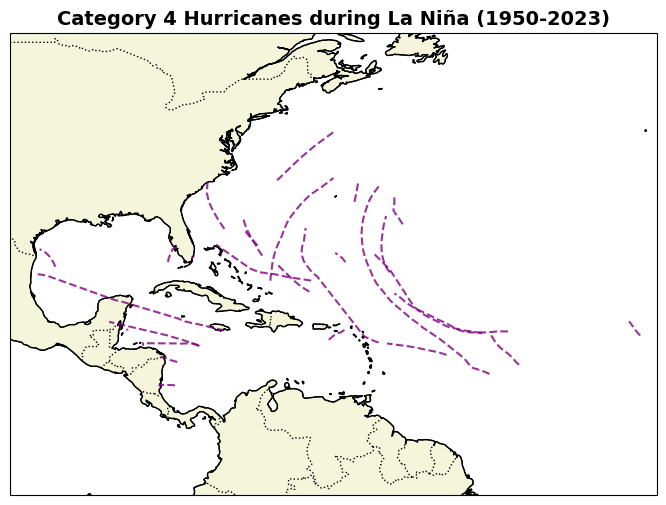

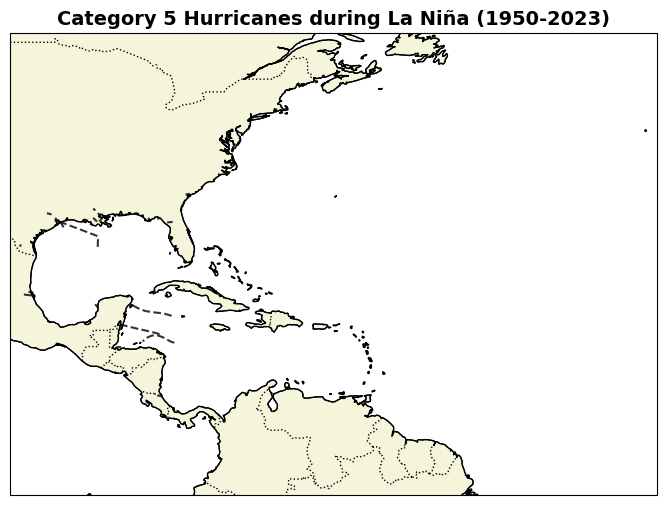

In [45]:
# Visualize hurricane tracks for El Niño and La Niña years

# Define function to classify hurricanes by category dynamically
def classify_category(intensity):
    """Classify hurricanes based on wind speed using the Saffir-Simpson scale."""
    if intensity < 64:
        return "Tropical Storm"
    elif 64 <= intensity < 83:
        return "Category 1"
    elif 83 <= intensity < 96:
        return "Category 2"
    elif 96 <= intensity < 113:
        return "Category 3"
    elif 113 <= intensity < 137:
        return "Category 4"
    else:
        return "Category 5"

# Apply classification to create a "Category" column
df_merged_ENSO["Category"] = df_merged_ENSO["Storm_Intensity"].apply(classify_category)

# Define ENSO phases
enso_phases = ["El Niño", "La Niña"]
categories = ["Tropical Storm", "Category 1", "Category 2", "Category 3", "Category 4", "Category 5"]

# Define category colors
category_colors = {
    "Tropical Storm": "gray",
    "Category 1": "yellow",
    "Category 2": "orange",
    "Category 3": "red",
    "Category 4": "purple",
    "Category 5": "black"
}

# Function to plot hurricane tracks dynamically based on category & ENSO phase
def plot_hurricane_tracks_by_category(df, category, enso_phase):
    """Plots hurricane tracks for a given category and ENSO phase."""
    
    # Filter dataset for the given ENSO phase and category
    df_filtered = df[(df["ENSO_Phase"] == enso_phase) & (df["Category"] == category)]

    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_extent([-100, -30, 0, 50], crs=ccrs.PlateCarree())  # Set map boundaries

    # Add land, coastlines, and country borders
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="beige")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    # Define line style for ENSO phases
    linestyle = "-" if enso_phase == "El Niño" else "--"  # Solid for El Niño, Dashed for La Niña

    # Plot hurricane tracks
    for storm_id in df_filtered["Storm_ID"].unique():
        storm_data = df_filtered[df_filtered["Storm_ID"] == storm_id].sort_values("ISO_Time")
        
        if len(storm_data) > 1:  # Ensure we have more than one point to create a track
            ax.plot(storm_data["Longitude"], storm_data["Latitude"], 
                    linestyle=linestyle, linewidth=1.5,
                    color=category_colors[category], alpha=0.8)

    # Title
    plt.title(f"{category} Hurricanes during {enso_phase} (1950-2023)", fontsize=14, fontweight="bold")

    # Show plot
    plt.show()

# 🔹 **Loop through each category and ENSO phase to create separate maps**
for enso_phase in enso_phases:
    for category in categories:
        plot_hurricane_tracks_by_category(df_merged_ENSO, category, enso_phase)

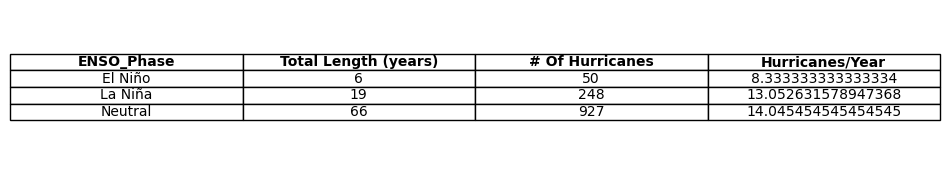

In [46]:
#Frequency of hurricanes during different ENSO stages

# Ensure ENSO Phase is categorized correctly
df_merged_ENSO["ENSO_Phase"] = df_merged_ENSO["ENSO_Phase"].astype(str)

# Total length (years) per ENSO Phase
total_years = df_merged_ENSO.groupby("ENSO_Phase")["Year"].nunique()

# Number of unique hurricanes per ENSO Phase
num_hurricanes = df_merged_ENSO.groupby("ENSO_Phase")["Storm_ID"].nunique()

# Hurricanes per year per ENSO Phase
hurricanes_per_year = num_hurricanes / total_years

# Combine into a DataFrame
enso_summary = pd.DataFrame({
    "Total Length (years)": total_years,
    "# Of Hurricanes": num_hurricanes,
    "Hurricanes/Year": hurricanes_per_year
})

# Reset index for better readability
enso_summary = enso_summary.reset_index()

# Display the summary table
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=enso_summary.values, colLabels=enso_summary.columns, cellLoc='center', loc='center')

# Formatting the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')

# Show the table
plt.show()


In [47]:
#Function to calculate moment for a storm

def get_first_moment(df):
    """Computes the first moment (mean latitude & longitude) of a hurricane track."""
    if df.empty:
        return None  # Handle empty cases

    mean_lat = df["Latitude"].mean()
    mean_lon = df["Longitude"].mean()
    return [mean_lon, mean_lat]  # Longitude first for mapping consistency

# Compute first moments for each unique hurricane track
moment_lst = [get_first_moment(df_merged_ENSO[df_merged_ENSO["Storm_ID"] == storm])
              for storm in df_merged_ENSO["Storm_ID"].unique()]

# Remove any None values (cases where hurricanes had missing data)
moment_lst = [m for m in moment_lst if m is not None]

# Convert to NumPy array for clustering
moment_arr = np.array(moment_lst)

print(f"Computed first moments for {len(moment_arr)} hurricane tracks.")

Computed first moments for 1195 hurricane tracks.


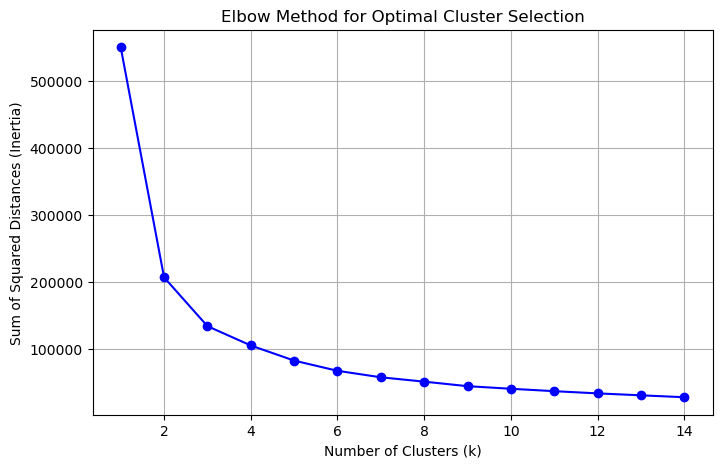

In [48]:
#Find number of clusters using Elbow-Method

# Initialize a list to store sum of squared distances (inertia)
sum_of_squares = []
K_range = range(1, 15)  # Testing K from 1 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(moment_arr)
    sum_of_squares.append(kmeans.inertia_)  # Store inertia value

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, sum_of_squares, 'bo-', markersize=6)  # Blue circles with a line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.grid()
plt.show()


In [49]:
#K-clustering of ENSO's impact on hurricanes

# Define map extent (adjust if needed)
extent = [-100, 0, 0, 60]  # Longitude and Latitude bounds

# Define optimal k from elbow method
optimal_k = 2  # Change this based on the elbow method result

# Apply K-Means clustering to first-moment hurricane tracks
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(moment_lst)

# Define cluster colors (extend list if more clusters are needed)
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']

# Plot first-moment clustering results
plt.figure(figsize=(10, 6))
ax = map_background(extent, title="K-Means Clustering of Hurricane Tracks")

# Plot each cluster with assigned color
for i, moment in enumerate(moment_lst):
    ax.plot(moment[0], moment[1], c=colors[labels[i]], marker='*')

plt.title(f'K-Means Clustering Result ({optimal_k} Clusters)')
plt.show()



NameError: name 'map_background' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
#Merge AMO data with Hurricane NA Basin data

#Load AMO data
amo_path = "../project1/csu_amo.csv"
df_amo = pd.read_csv(amo_path)

#Filter Hurricane data to start at 1950
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Convert AMO data to long format
df_amo_long = df_amo.melt(id_vars=["Year"], var_name="Month", value_name="AMO_Anomaly")

# Ensure Month names match the hurricane dataset
month_map = {
    "Jan": "January", "Feb": "February", "Mar": "March", "Apr": "April", "May": "May", "Jun": "June",
    "Jul": "July", "Aug": "August", "Sep": "September", "Oct": "October", "Nov": "November", "Dec": "December"
}
df_amo_long["Month"] = df_amo_long["Month"].map(month_map)

# Convert data types to match hurricane dataset
df_amo_long["Year"] = df_amo_long["Year"].astype(int)
df_amo_long["Month"] = df_amo_long["Month"].astype(str)

print(df_amo_long.head())  # Check transformed data

df_merge_amo = df_hurricane.merge(df_amo_long, on=["Year", "Month"], how="left")

# Save merged dataset
df_merge_amo.to_csv("../project1/merged_amo.csv", index=False)


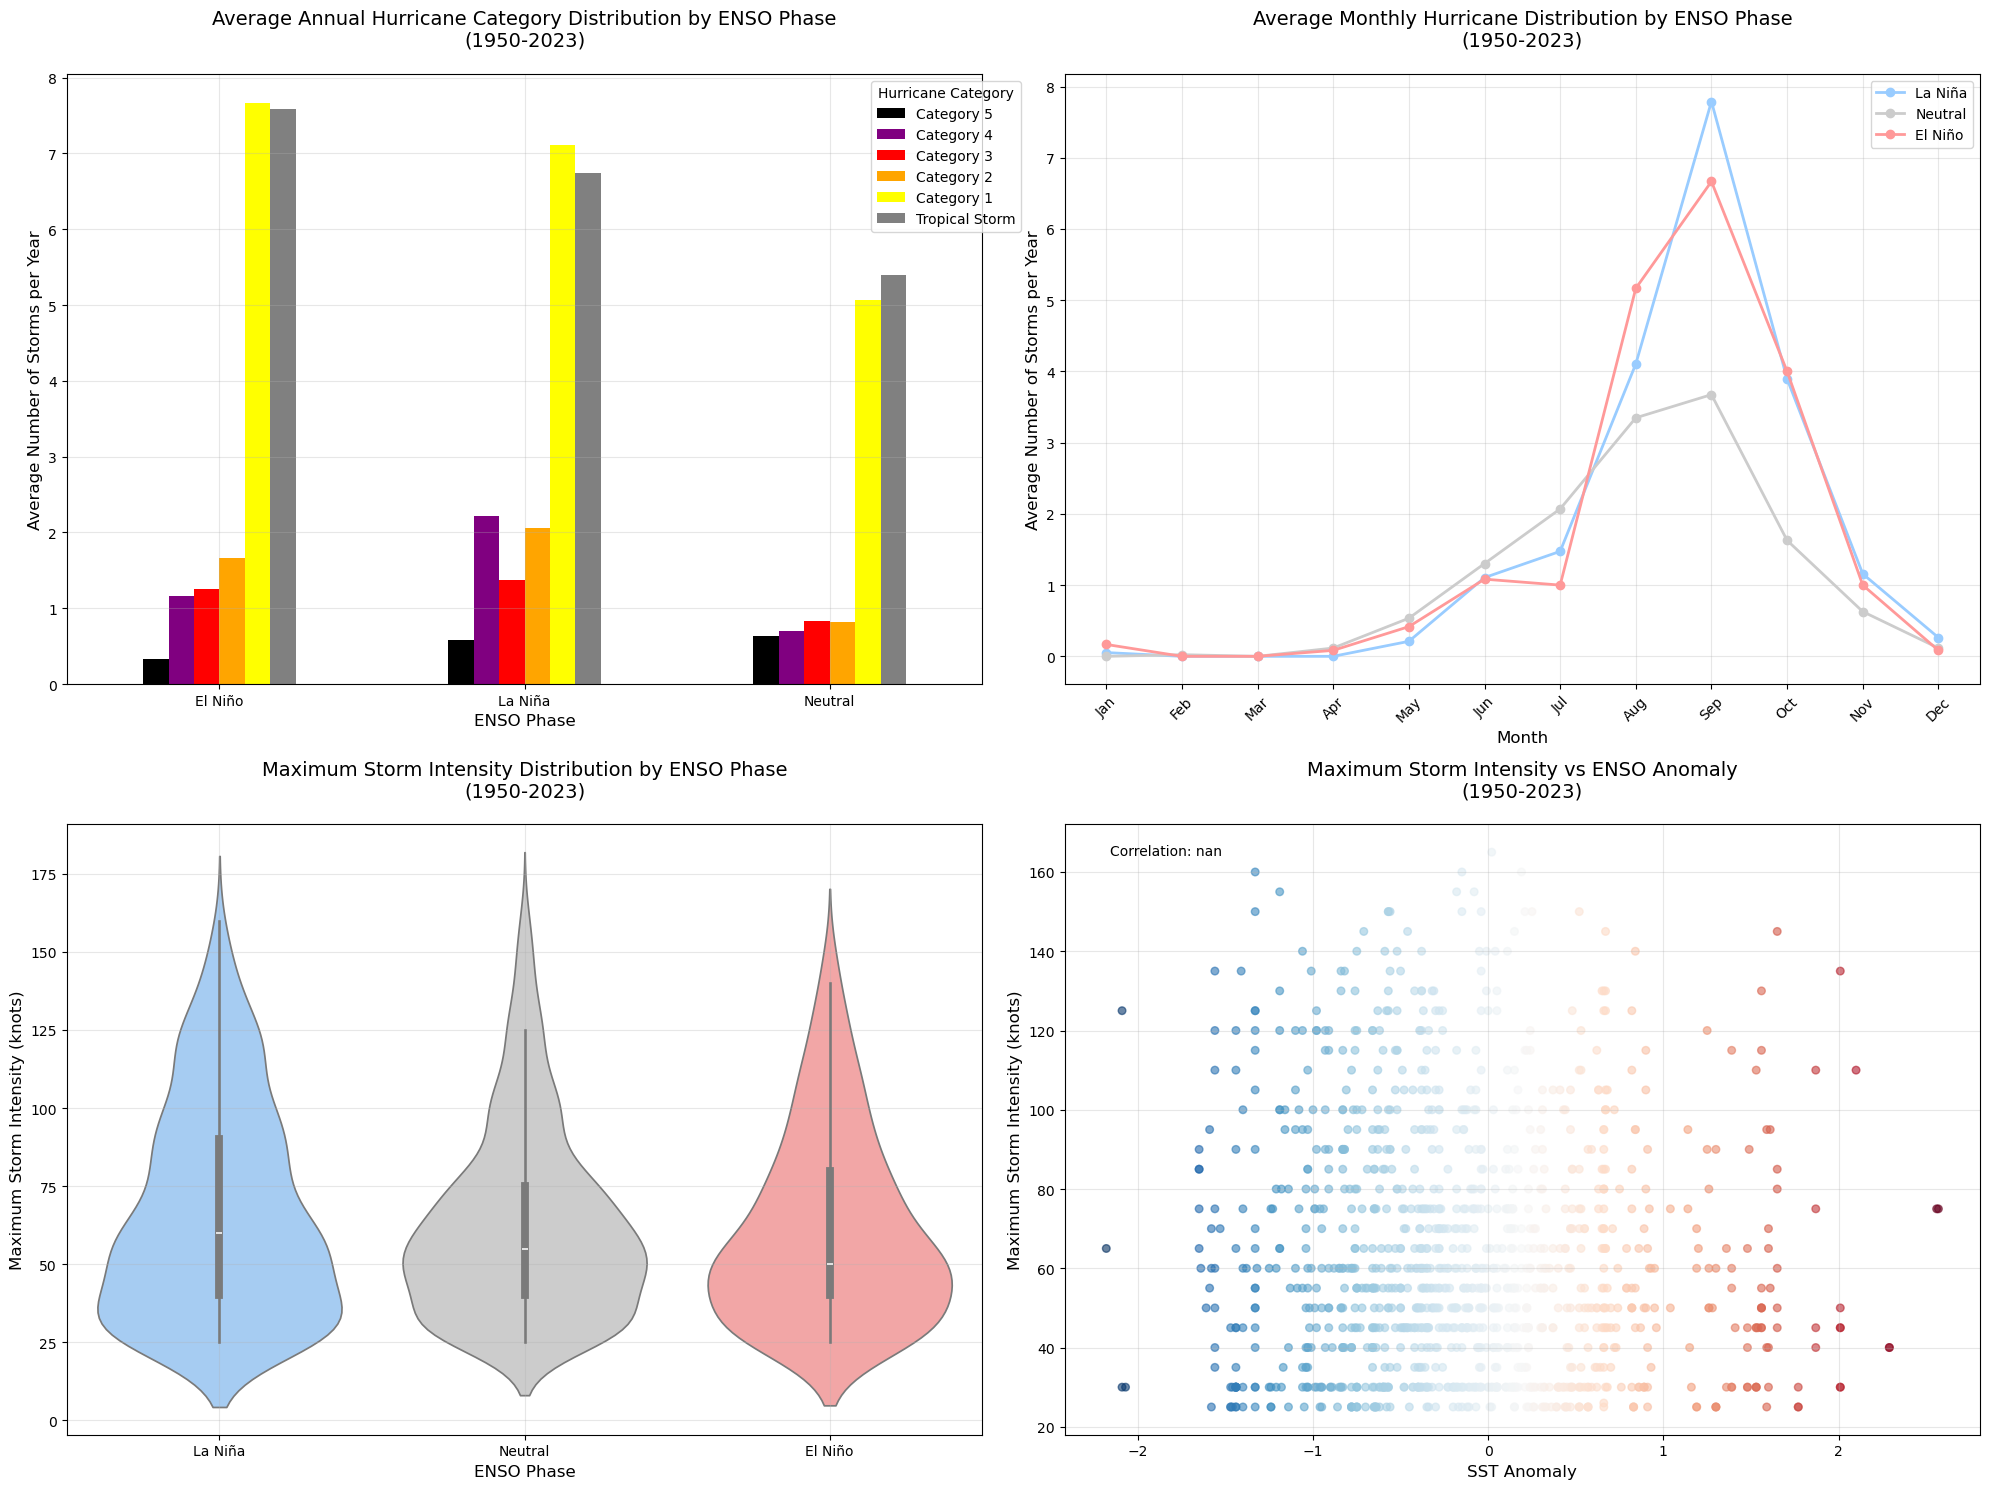


Statistical Summary (1950-2023):

Analysis period: 1950-2023 (74 years)

Total number of storms per ENSO phase:
ENSO_Phase
Neutral    578
La Niña    381
El Niño    236
Name: count, dtype: int64

Average Maximum Intensity per ENSO Phase:
                 mean        std  count
ENSO_Phase                             
El Niño     61.169491  30.101475    236
La Niña     66.561676  33.992870    381
Neutral     62.425045  30.083529    567


In [50]:


# Function to classify hurricanes based on wind speed
def categorize_hurricane(max_wind_speed):
    """Classify hurricanes based on maximum wind speed"""
    if 34 <= max_wind_speed < 64:
        return "Tropical Storm"
    elif max_wind_speed < 83:
        return "Category 1"
    elif max_wind_speed < 96:
        return "Category 2"
    elif max_wind_speed < 113:
        return "Category 3"
    elif max_wind_speed < 137:
        return "Category 4"
    else:
        return "Category 5"

# Read and process the ENSO dataset
df = df_merged_ENSO.copy()

# Convert date and limit time range to 1950-2023
df['Date'] = pd.to_datetime(df['ISO_Time'])
df['Year'] = df['Date'].dt.year
df = df[(df['Year'] >= 1950) & (df['Year'] <= 2023)]

# Get maximum hurricane intensity for each storm
max_intensities = df.groupby('Storm_ID')['Storm_Intensity'].max()
unique_storms = df.drop_duplicates('Storm_ID').copy()
unique_storms['Max_Intensity'] = unique_storms['Storm_ID'].map(max_intensities)

# Categorize hurricanes by intensity
unique_storms['Category'] = unique_storms['Storm_ID'].map(lambda x: categorize_hurricane(max_intensities[x]))

# Define ENSO phases
unique_storms['ENSO_Phase'] = unique_storms['SST_Anomaly'].apply(
    lambda x: 'El Niño' if x > 0.5 else 'La Niña' if x < -0.5 else 'Neutral'
)

# Create yearly statistics
yearly_data = pd.DataFrame(index=range(1950, 2024))
yearly_data['ENSO_Phase'] = unique_storms.groupby('Year')['ENSO_Phase'].first()

# Count number of years in each phase
phase_years = yearly_data['ENSO_Phase'].value_counts()

# Create figure
fig = plt.figure(figsize=(20, 15))

# Define colors for hurricane categories
category_colors = {
    "Tropical Storm": "gray",
    "Category 1": "yellow",
    "Category 2": "orange",
    "Category 3": "red",
    "Category 4": "purple",
    "Category 5": "black"
}

# Colors for ENSO phases (dynamically mapped)
phase_colors_map = {'El Niño': '#FF9999', 'La Niña': '#99CCFF', 'Neutral': '#CCCCCC'}
existing_phases = list(unique_storms['ENSO_Phase'].unique())  # Get actual phases in data
phase_colors = [phase_colors_map[phase] for phase in existing_phases]

### **1️⃣ Category Distribution by ENSO Phase**
plt.subplot(2, 2, 1)
category_order = ["Category 5", "Category 4", "Category 3", "Category 2", "Category 1", "Tropical Storm"]
cat_counts = pd.crosstab(unique_storms['ENSO_Phase'], unique_storms['Category'])

# Ensure cat_counts allows float values
cat_counts = cat_counts.astype(float)

# Normalize by years in each phase
for phase in cat_counts.index:
    cat_counts.loc[phase] = (cat_counts.loc[phase] / phase_years[phase]).astype(float)

cat_counts = cat_counts[category_order]

ax = cat_counts.plot(kind='bar', ax=plt.gca(), 
                     color=[category_colors[cat] for cat in category_order])
plt.title('Average Annual Hurricane Category Distribution by ENSO Phase\n(1950-2023)', fontsize=14, pad=20)
plt.xlabel('ENSO Phase', fontsize=12)
plt.ylabel('Average Number of Storms per Year', fontsize=12)
plt.legend(title='Hurricane Category', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

### **2️⃣ Monthly Hurricane Distribution by ENSO Phase**
plt.subplot(2, 2, 2)
unique_storms['Month'] = unique_storms['Date'].dt.month
monthly_counts = pd.crosstab(unique_storms['ENSO_Phase'], unique_storms['Month'])

# Ensure all months are present
for month in range(1, 13):
    if month not in monthly_counts.columns:
        monthly_counts[month] = 0
monthly_counts = monthly_counts.reindex(columns=range(1, 13)).fillna(0)
monthly_counts = monthly_counts.astype(float)

# Normalize by years in each ENSO phase
for phase in monthly_counts.index:
    monthly_counts.loc[phase] = monthly_counts.loc[phase].astype(float) / float(phase_years[phase])

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, phase in enumerate(existing_phases):
    plt.plot(range(len(month_names)), monthly_counts.loc[phase], 
             marker='o', label=phase, color=phase_colors[i], linewidth=2)

plt.title('Average Monthly Hurricane Distribution by ENSO Phase\n(1950-2023)', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Number of Storms per Year', fontsize=12)
plt.legend()
plt.xticks(range(len(month_names)), month_names, rotation=45)
plt.grid(True, alpha=0.3)

### **3️⃣ Violin Plot: Max Intensity by ENSO Phase**
plt.subplot(2, 2, 3)
sns.violinplot(data=unique_storms, x='ENSO_Phase', y='Max_Intensity', hue='ENSO_Phase', 
               palette=phase_colors, legend=False)
plt.title('Maximum Storm Intensity Distribution by ENSO Phase\n(1950-2023)', fontsize=14, pad=20)
plt.xlabel('ENSO Phase', fontsize=12)
plt.ylabel('Maximum Storm Intensity (knots)', fontsize=12)
plt.grid(True, alpha=0.3)

### **4️⃣ Scatter Plot: Max Intensity vs ENSO Anomaly**
plt.subplot(2, 2, 4)
plt.scatter(unique_storms['SST_Anomaly'], unique_storms['Max_Intensity'], 
            c=unique_storms['SST_Anomaly'], cmap='RdBu_r', alpha=0.6, s=30)

# Add regression line
z = np.polyfit(unique_storms['SST_Anomaly'], unique_storms['Max_Intensity'], 1)
p = np.poly1d(z)
x_range = np.linspace(unique_storms['SST_Anomaly'].min(), unique_storms['SST_Anomaly'].max(), 100)
plt.plot(x_range, p(x_range), color='black', linestyle='--', alpha=0.5)

# Add correlation coefficient
correlation = np.corrcoef(unique_storms['SST_Anomaly'], unique_storms['Max_Intensity'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=10)

plt.title('Maximum Storm Intensity vs ENSO Anomaly\n(1950-2023)', fontsize=14, pad=20)
plt.xlabel('SST Anomaly', fontsize=12)
plt.ylabel('Maximum Storm Intensity (knots)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary (1950-2023):")
print(f"\nAnalysis period: 1950-2023 ({len(yearly_data)} years)")
print("\nTotal number of storms per ENSO phase:")
print(unique_storms['ENSO_Phase'].value_counts())

print("\nAverage Maximum Intensity per ENSO Phase:")
print(unique_storms.groupby('ENSO_Phase')['Max_Intensity'].agg(['mean', 'std', 'count']))
